<a href="https://colab.research.google.com/github/theresatvan/cs-gy-6613-assignments/blob/main/ttv2006_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic Regression#

You are interviewing with Google’s data science team having the responsibility of predicting the Click Through Rate (CTR) of ads they place on multiple web properties. Your hiring manager keen on testing you out, suggests to download [this dataset](https://www.kaggle.com/competitions/avazu-ctr-prediction/data) and asks you to code up a model that predicts the CTR based on Logistic Regression.

#Environment Setup (10 points)#

You will deliver this assignment in the form of a Colab notebook (or a Github repo if you like). Both must be configured to allow anyone to run the code (in Colab this is `Run All`) and get the results. Setup your environment that can automatically download the data from Kaggle and store them in a location. You may [want to read for this task](https://www.kaggle.com/docs/api#interacting-with-datasets) and ensure that this task is implemented with Python.

**Answer:**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

! mkdir ~/.kaggle
! cp '/content/gdrive/My Drive/Kaggle/kaggle.json' ~/.kaggle/
! chmod 600 '/root/.kaggle/kaggle.json'

! kaggle competitions download -c avazu-ctr-prediction
! unzip -o '/content/avazu-ctr-prediction.zip' -d '/content'

Mounted at /content/gdrive
100% 1.19G/1.19G [00:43<00:00, 32.0MB/s]
100% 1.19G/1.19G [00:43<00:00, 29.0MB/s]
Archive:  /content/avazu-ctr-prediction.zip
  inflating: /content/sampleSubmission.gz  
  inflating: /content/test.gz        
  inflating: /content/train.gz       


#Data Preprocessing (30 points)#

Preprocess the data you are given to your liking. This may include dropping some columns you wont use, addressing noisy or missing data etc.

Use Pandas as a dataframe abstraction for this task. You can learn about Pandas here:

https://youtu.be/PcvsOaixUh8

Ultimately this task has to result to a dataframe that you will use for the training and testing the classifier.

**Answer:**

First, load the data set into a `pandas` DataFrame that we can transform.

In [264]:
import pandas as pd

df = pd.read_csv('/content/train.gz', compression='gzip', nrows=1000000)

df.head(6)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
5,1.000072e+19,0,14102100,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,...,1,0,16920,320,50,1899,0,431,100077,117


Check for any null values in the data set. If they exist then we will want to remove any rows with the null values. It will also be useful to check the data types of each column.

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1000000 non-null  float64
 1   click             1000000 non-null  int64  
 2   hour              1000000 non-null  int64  
 3   C1                1000000 non-null  int64  
 4   banner_pos        1000000 non-null  int64  
 5   site_id           1000000 non-null  object 
 6   site_domain       1000000 non-null  object 
 7   site_category     1000000 non-null  object 
 8   app_id            1000000 non-null  object 
 9   app_domain        1000000 non-null  object 
 10  app_category      1000000 non-null  object 
 11  device_id         1000000 non-null  object 
 12  device_ip         1000000 non-null  object 
 13  device_model      1000000 non-null  object 
 14  device_type       1000000 non-null  int64  
 15  device_conn_type  1000000 non-null  int64  
 16  C

From the above cell we can see that there are categorical attributes as well as numerical attributes.

For now we will focus on the numerical attributes.

The `hour` attribute contains year, month, day, and hour as an integer data type. We want to convert it to a datetime data type and seperate year, month, day, hour, and day of the week each into its own column.

In [266]:
# convert hour column to datetime
df['hour'] = pd.to_datetime(df['hour'], format='%y%m%d%H')

# extract date details and separate into columns
df['year'] = df['hour'].dt.year
df['month'] = df['hour'].dt.month
df['day'] = df['hour'].dt.day
df['day_of_week'] = df['hour'].dt.dayofweek 
df['hour'] = df['hour'].dt.hour

df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C16,C17,C18,C19,C20,C21,year,month,day,day_of_week
0,1.000009e+18,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,-1,79,2014,10,21,1
1,1.000017e+19,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,100084,79,2014,10,21,1
2,1.000037e+19,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,100084,79,2014,10,21,1
3,1.000064e+19,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,50,1722,0,35,100084,79,2014,10,21,1
4,1.000068e+19,0,0,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,50,2161,0,35,-1,157,2014,10,21,1


Now that we have all of our columns, keep track of which columns are categorical attributes and which one are numerical attributes.

In [267]:
# Retrieve all numerical attributes
numerical = [col for col in df.columns if df[col].dtype != "object"]
# Retrieve all categorical attributesy
categorical = [col for col in df.columns if df[col].dtype == "object"]

Now let's check summary statistics of each numerical attribute.



In [268]:
df.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,year,month,day,day_of_week
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.0,1000000.0,1000000.0
mean,9.376314e+18,0.160219,2.581368,1005.088166,0.229922,1.025540,0.223363,18262.203151,318.965808,56.495546,2041.031112,1.452262,190.779388,45505.857239,69.936118,2014.0,10.0,21.0,1.0
std,5.236908e+18,0.366809,1.493256,1.156928,0.464627,0.453899,0.667164,3510.366302,19.452897,36.546944,441.200965,1.362637,273.439286,49843.810147,38.513846,0.0,0.0,0.0,0.0
min,9.984920e+12,0.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000,2014.0,10.0,21.0,1.0
25%,4.846660e+18,0.000000,1.000000,1005.000000,0.000000,1.000000,0.000000,15707.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,43.000000,2014.0,10.0,21.0,1.0
50%,9.834387e+18,0.000000,3.000000,1005.000000,0.000000,1.000000,0.000000,19251.000000,320.000000,50.000000,2161.000000,1.000000,39.000000,-1.000000,61.000000,2014.0,10.0,21.0,1.0
75%,1.373053e+19,0.000000,4.000000,1005.000000,0.000000,1.000000,0.000000,21153.000000,320.000000,50.000000,2420.000000,3.000000,297.000000,100084.000000,79.000000,2014.0,10.0,21.0,1.0
max,1.844670e+19,1.000000,5.000000,1012.000000,7.000000,5.000000,5.000000,21705.000000,1024.000000,1024.000000,2497.000000,3.000000,1835.000000,100248.000000,195.000000,2014.0,10.0,21.0,1.0


It looks like for `year`, `month`, `day`, and `day_of_week` attributes, there is only one value for every row. It seems as that the only significant date detail is going to be `hour`. Let's analyze this further by looking at density distribution plots for each numerical attribute.

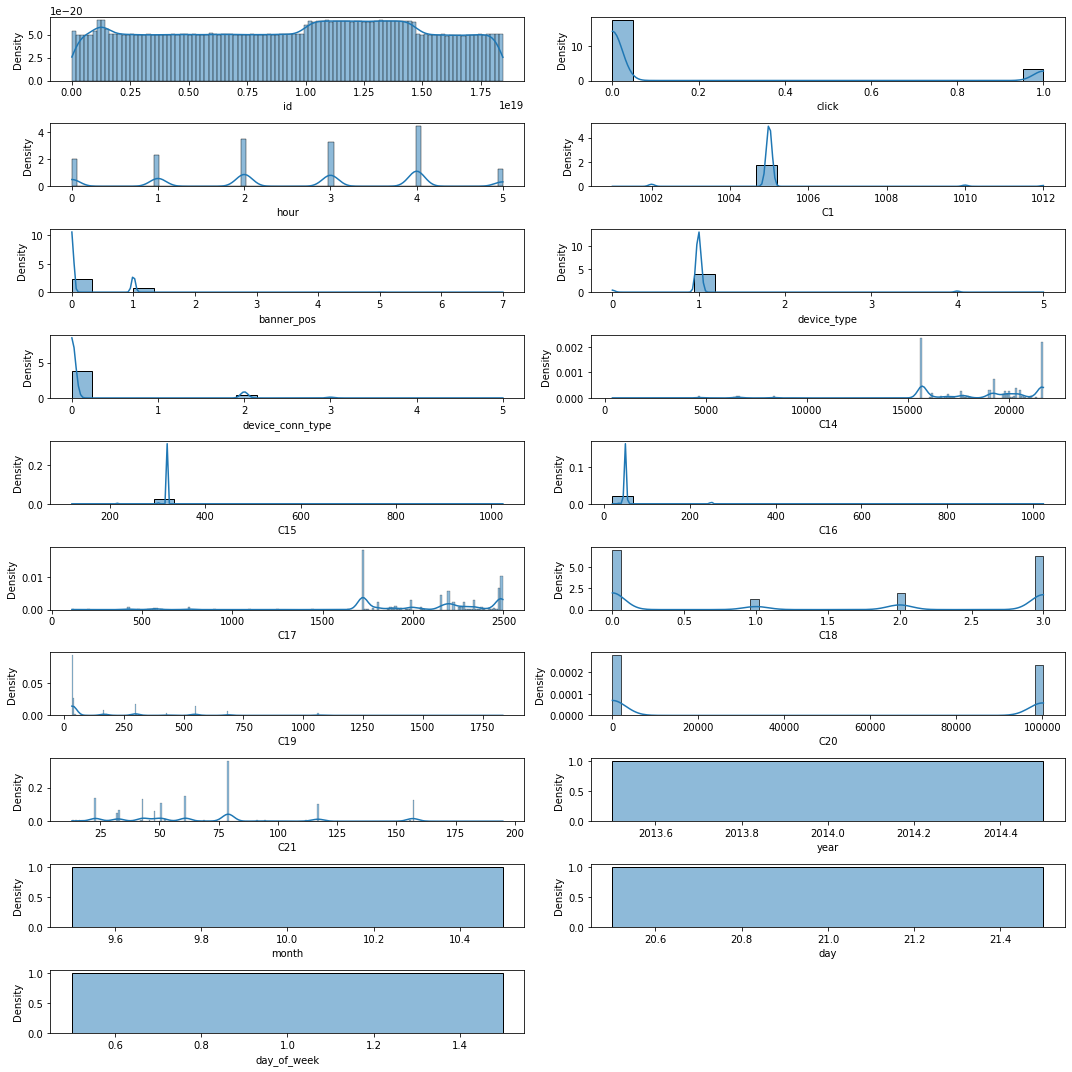

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

fig, axs = plt.subplots(nrows=math.ceil(len(numerical)/2), ncols=2, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(numerical):
  sns.histplot(data=df[numerical], x=col, kde=True, ax=axs[i], stat='density')

fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

Some observations from density distributions above:

*   `click` is our target variable, the target distribution is heavily imbalanced
*   `year`, `month`, `day`, and `day_of_week` appear to only have one value for every row

We will address the target distribution imbalance later.

For now, we will look for any highly correlated predictors and drop a feature where there is a pair of highly correlated features.

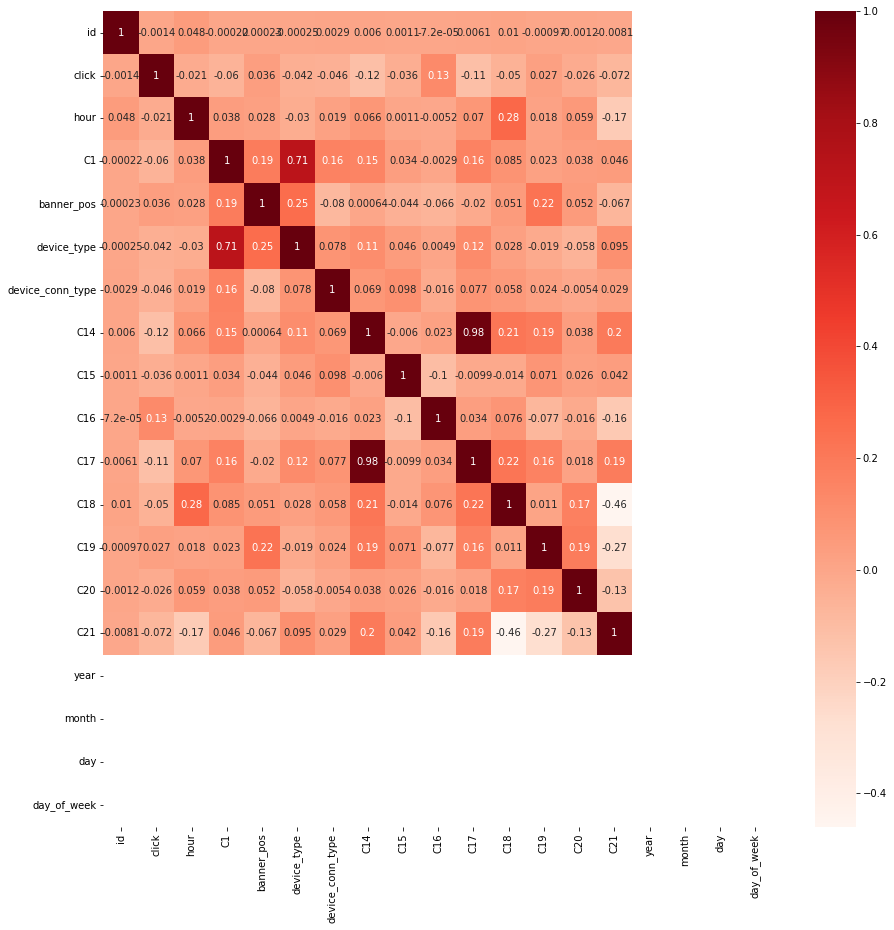

In [270]:
cor = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

From the figure above, we can see

*   `device_type` and `C1` are highly positive correlated pairs so drop `C1`
*   `C18` and `C21` are highly negative correlated pairs so drop `C21`
*   `C14` and `C17` are highly positive correlated pairs so drop `C17`
*   `year`, `month`, `day`, and `day_of_week` have no significance so we can drop these columns

In [271]:
df = df.drop(columns=['C1', 'C21', 'C17', 'year', 'month', 'day', 'day_of_week'], axis=1)

Let's also check `id` column for total unique values.

In [272]:
print(len(df['id'].unique()))

1000000


Since every row has a unique `id`, we can drop this column as it has no significance on our model.

In [273]:
df = df.drop(columns=['id'], axis=1)

Now we will address the dataset imbalance by employing undersampling to get a balanced ratio of clicks to nonclicks.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


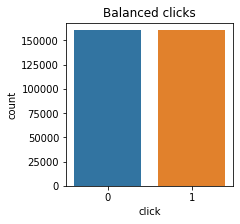

Amount of nonclicks: 160219
Amount of clicks: 160219


In [274]:
# Shuffle the dataset
shuffled_df = df.sample(frac=1,random_state=4)

# Retrieve all rows where click = 1
click = df.loc[shuffled_df['click'] == 1]

# Randomly retrieve rows where click = 0. Amount of rows to retrieve equals amount of rows where click = 1
nonclick = shuffled_df.loc[shuffled_df['click'] == 0].sample(n=click.shape[0],random_state=42)

# Concatenate both dataframes
normalized_df = pd.concat([click, nonclick])

# Plot the dataset after the undersampling
plt.figure(figsize=(3,3))
sns.countplot('click', data=normalized_df)
plt.title('Balanced clicks')
plt.show()

print('Amount of nonclicks: {}'.format(nonclick.shape[0]))
print('Amount of clicks: {}'.format(click.shape[0]))

After undersampling, there are 160,219 rows where `click` is 1 and 160,219 rows where `click` is 0, giving us a total of 320,438 rows.

Now let's examine the categorical features.

In [275]:
for col in categorical:
  print('Unique values for {}: {}'.format(col, len(normalized_df[col].unique())))

Unique values for site_id: 1566
Unique values for site_domain: 1433
Unique values for site_category: 20
Unique values for app_id: 1649
Unique values for app_domain: 111
Unique values for app_category: 23
Unique values for device_id: 31314
Unique values for device_ip: 150723
Unique values for device_model: 3773


Separate target variable `click` from predictor variables. We label encode the categorical features, then split the data set into a training set and a test set.

In [276]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Separate columns of predictor variables from the target variable
X = normalized_df.drop(columns=['click'], axis=1)
y = normalized_df[['click']]

# Label encode the categorical variables
le = preprocessing.LabelEncoder()
for col in categorical: X[col] = le.fit_transform(X[col])

# Split the data set into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 15)

Now standardize the data.

In [277]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  

#Logistic Regression (40 points)#

Implement the logistic regression solution to the prediction problem that can work with Stochastic Gradient Descent (SGD).

Show clearly all equations of the gradient and include comments in either markdown or Python (inline to code) explaining every stage of processing. Also, highlight any enhancements you may have done to improve performance.

**Answer:**

To find probability of a click occurring, we want to use the formula

<div align='center'>
$p(y=1| \mathbf{x}) = σ(α) = \frac{1}{1 + \text{exp}(-α)}$
</div>

We will use logistic regression to find a model where $α = \mathbf{w}^T\mathbf{x}$ such that

<div align='center'>
$p_{model}(y=1| \mathbf{x}) = \hat{y} = σ(\mathbf{w}^T\mathbf{x})$
</div>

where $\mathbf{w}$ is the coefficients to the predictors $\mathbf{x}$, so $\mathbf{w}^T\mathbf{x}$ is actually the linear regression. We are able to create a logistic regression model from the linear regression by using the sigmoid function σ.



We use the binary cross-entropy loss function to calculate the loss of our logistic regression model, given as

<div align='center'>
$L(\mathbf{w}) = -∑^{m}_{i=1}[y_i \text{ln} \hat{y} + (1 - y_i) \text{ln} (1 - \hat{y_i})] \\ = -∑^{m}_{i=1}[y_i \mathbf{w}^T\mathbf{x} + \text{ln} (1 + \text{exp}(\mathbf{w}^T\mathbf{x})]$
</div>

We want to minimize loss with respect to $\mathbf{w}$. Gradient descent can be used to gradually move $\mathbf{w}$ to the optimal $\mathbf{w}'$ that will minimize the loss function. The formula is given below, where $η$ is the learning rate and the process is repeated for a certain amount of epochs. Ideally, we want to see $\mathbf{w}$ converge to $\mathbf{w}'$.

<div align='center'>
$\mathbf{w}_{k+1} = \mathbf{w}_k - η \triangledown L(\mathbf{w})$
</div>

However this method runs the risk of getting stuck in a local minima. To reduce the likelihood of this issue from occurring we will use stochastic gradient descent. 

With gradient descent, every sample of $\mathbf{x}$ is considered when updating $\mathbf{w}$. Stochastic gradient on the other hand only uses one random sample from $\mathbf{x}$ to update $\mathbf{w}$. Though it may take more iterations to reach the optimal $\mathbf{w}'$, stochastic gradient descent is computationally less expensive as datasets can be very large. Stochastic gradient descent is less likely to be caught in a local minima because it introduces noise with its random sampling. The idea is that with enough noise, the algorithm can escape the local minima (similar to the concept of Simulated Annealing). 

There is also the variation of batch stochastic gradient descent, where instead of a single random sample, a batch of a discrete amount of random samples are used to update $\mathbf{w}$. For example, if a batch consists of $m$ random samples, then the below formula can be used to calculate the gradient:

<div align='center'>
$\triangledown L(\mathbf{w}) = ∑^{m}_{i=1}(\hat{y}_i - y_i)x_i$
</div>

In [289]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

# Use stochastic gradient descent to find a model fitted to the training set
sgd = SGDClassifier(loss="log", max_iter=1000).fit(X_train, y_train.values.flatten())
# Obtain predicted values using the fitted model on the test set
y_hat = sgd.predict_proba(X_test)[:,1]
print("Mean accuracy of Stochastic Gradient Descent: {}".format(sgd.score(X_test, y_test)))

# Use sklearn's LogisticRegression class as comparison to the stochastic gradient approach
lr = LogisticRegression().fit(X_train, y_train.values.flatten())
lr.predict_proba(X_test)
print("Mean accuracy of Logistic Regression: {}".format(lr.score(X_test, y_test)))

Mean accuracy of Stochastic Gradient Descent: 0.6174114758873216
Mean accuracy of Logistic Regression: 0.6181812507801773


As we can see from the results above, the mean accuracy of the stochastic gradient approach and `sklearn`'s built-in logistic regression class are pretty close in value. However, neither appear to be a good fit.

#Performance Results (20 points)#

Plot the precision vs recall curve of your classifier. Clearly explain the tradeoff between the two quantities and the shape of the curve.

**Answer:**



Precision refers to the proportion of positive classifications that were actually correct.

<div align='center'>
$Precision = \frac{TP}{TP + FP}$
</div>

Recall refers to the proportion of actual positives that were identified correctly.

<div align='center'>
$Recall = \frac{TP}{TP + FN}$
</div>

Ideally, a good fit will have high recall and high precision. However, there is a tradeoff between recall and precision. If a model aims to increase precision, recall is reduced, and vice versa.

Text(0, 0.5, 'Precision')

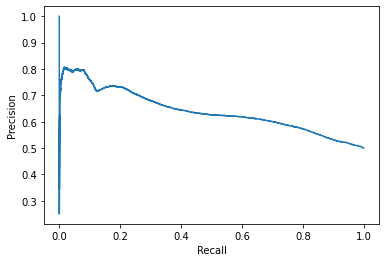

In [290]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

As we can see from the precision vs. recall plot above, the model is not a good fit.